In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from coffea import hist, processor 
from coffea.hist import plot
from coffea.util import load, save

In [2]:
year='2018'
hists = load('../hists/darkhiggs'+year+'.scaled')

data={
    '2016':{
        'sr': 'MET',
        'wmcr': 'MET',
        'tmcr': 'MET',
        'wecr': 'SingleElectron',
        #'wecr': 'EGamma',
        'tecr': 'SingleElectron',
        #'tecr': 'EGamma',
        'zmcr': 'MET',
        'zecr': 'SingleElectron',
        #'zecr': 'EGamma',
        'gcr': 'SinglePhoton'
        #'gcr': 'EGamma'
    },
    '2017':{
        'sr': 'MET',
        'wmcr': 'MET',
        'tmcr': 'MET',
        'wecr': 'SingleElectron',
        #'wecr': 'EGamma',
        'tecr': 'SingleElectron',
        #'tecr': 'EGamma',
        'zmcr': 'MET',
        'zecr': 'SingleElectron',
        #'zecr': 'EGamma',
        'gcr': 'SinglePhoton'
        #'gcr': 'EGamma'
    },
    '2018':{
        'sr': 'MET',
        'wmcr': 'MET',
        'tmcr': 'MET',
        'wecr': 'EGamma',
        'tecr': 'EGamma',
        'zmcr': 'MET',
        'zecr': 'EGamma',
        'gcr': 'EGamma'
    },
}

gentype_map = {
    'garbage':  0,
    'xbb':      1,
    'tbcq':     2,
    'tbqq':     3,
    'zcc':      4,
    'wcq':      5,
    'vqq':      6,
    'bb':       7,
    'bc':       8,
    'b':        9,
    'cc' :     10,
    'c':       11,
    'other':   12
}

In [3]:
data_hists   = hists['data']
bkg_hists    = hists['bkg']
signal_hists = hists['sig']

In [4]:
data_hists['recoil'].identifiers('process')

[<StringBin (MET) instance at 0x7f7652886898>,
 <StringBin (EGamma) instance at 0x7f7652886978>]

In [120]:
exp = 0
region = 'zecr'
mass_map = {
    0 :'underflow', 
    1 :'mass0', 
    2 :'mass1', 
    3 :'mass2', 
    4 :'mass3', 
    5 :'mass4', 
    6 :'overflow',
    None: ''
}
category_map = {
    0 :'underflow', 
    1 :'monojet', 
    2 :'monohs',
    3 :'overflow',
    None : '',
}

mass= None
category= None
sys='nominal'

print('------------------------')
print('------------------------')
print('Category:', region, mass_map[mass], category_map[category])
print('Systematic:', sys)
#print('------------------------')
print('------------------------')
print('------------------------')
for p in bkg_hists['template'].identifiers('process'):
    yld_array = bkg_hists['template'].integrate('region',region).integrate('process', p).integrate('systematic',sys).sum('gentype','recoil',overflow='all').values(overflow='all')
    if () in yld_array:
        yld = yld_array[()][mass,category].sum()
        exp += yld
        print(p, '%.1f' % yld)

print('------------------------')
print('Total expected:', '%.1f' % exp)
print('------------------------')

for p in signal_hists['template'].identifiers('process'):
    yld_array = signal_hists['template'].integrate('region',region).integrate('process', p).integrate('systematic',sys).sum('gentype','recoil',overflow='all').values(overflow='all')
    if () in yld_array:
        yld = yld_array[()][mass,category].sum()
        print(p, '%.1f' % yld)
        print(p,'S/B %.3f' % (yld/exp))
        print(p,'S/sqrt(B) %.1f' % (yld/np.sqrt(exp)))
        #print(p,'Fraction %.2f' % (yld/np.cumsum(yld_array[()])[16]))
        print('------------------------')

if not region == '':
    yld_array = data_hists['template'].integrate('region',region).integrate('process', data[year][region]).integrate('systematic',sys).sum('gentype','recoil',overflow='all').values(overflow='all')
    if () in yld_array:
        yld = yld_array[()][mass,category].sum()
        print('Total observed:', '%.1f' % yld)   
print('------------------------')
print()

------------------------
------------------------
Category: zecr  
Systematic: nominal
------------------------
------------------------
Hbb 22.1
DY+HF 3971.7
DY+LF 34761.0
WW 123.0
WZ 401.0
ZZ 305.3
ST 187.8
TT 949.6
W+HF 52.5
W+LF 243.0
QCD 249.2
------------------------
Total expected: 41266.0
------------------------
Total observed: 37569.0
------------------------



In [131]:
#To optimize cuts based on process yield, i.e. you wanna test some background rejection
exp = 0
region = 'zecr'
sys = 'nominal'
variable = 'met'
cut_bin = None
nbins = data_hists[variable].integrate('region').integrate('process', 'MET').sum('gentype',overflow='all').values(overflow='all')[()].size
cut_value_array = data_hists[variable].integrate('region').integrate('process', 'MET').axis(variable).edges(overflow='all')

print('------------------------')
print('------------------------')
print('Category:', region)
print('Systematic:', sys)
#print('------------------------')
if cut_bin!=None: print(variable,'> %.2f' % cut_value_array[()][cut_bin])
print('------------------------')
print('------------------------')
for p in bkg_hists[variable].identifiers('process'):
    yld_array = bkg_hists[variable].integrate('region',region).integrate('process', p).sum('gentype',overflow='all').values(overflow='all')
    if () in yld_array:
        #yld = np.cumsum(yld_array[()])[nbins-1]
        yld = yld_array[()].sum()
        if cut_bin!=None: yld = yld - np.cumsum(yld_array[()])[cut_bin]
        exp += yld
        print(p, '%.1f' % yld)

print('------------------------')
print('Total expected:', '%.1f' % exp)
print('------------------------')

for p in signal_hists[variable].identifiers('process'):
    yld_array = signal_hists[variable].integrate('region',region).integrate('process', p).sum('gentype',overflow='all').values(overflow='all')
    if () in yld_array:
        #yld = np.cumsum(yld_array[()])[nbins-1]
        yld = yld_array[()].sum()
        if cut_bin!=None: yld = yld - np.cumsum(yld_array[()])[cut_bin]
        print(p, '%.1f' % yld)
        print(p,'S/B %.3f' % (yld/exp))
        print(p,'S/sqrt(B) %.1f' % (yld/np.sqrt(exp)))
        #print(p,'Fraction %.2f' % (yld/np.cumsum(yld_array[()])[16]))
        print('------------------------')

if not region == 'sr':
    yld_array = data_hists[variable].integrate('region',region).integrate('process', data[year][region]).sum('gentype',overflow='all').values(overflow='all')
    if () in yld_array:
        #yld = np.cumsum(yld_array[()])[nbins-1]
        yld = yld_array[()].sum()
        if cut_bin!=None: yld = yld - np.cumsum(yld_array[()])[cut_bin]
        print('Total observed:', '%.1f' % yld)   
print('------------------------')
print()

------------------------
------------------------
Category: zecr
Systematic: nominal
------------------------
------------------------
Hbb 22.1
DY+HF 3971.7
DY+LF 34761.0
WW 123.0
WZ 401.0
ZZ 305.3
ST 187.8
TT 949.6
W+HF 52.5
W+LF 243.0
QCD 249.2
------------------------
Total expected: 41266.0
------------------------
Total observed: 37569.0
------------------------



In [ ]:
#To optimize cuts based on gentype yield, i.e. define fat-jet tagger pass/fail 
exp = 0
region = 'sr'
variable = 'ZHbbvsQCD'
cut_bin = 10
nbins = data_hists[variable].integrate('region').integrate('process', 'MET').sum('gentype').values()[()].size
cut_value_array = data_hists[variable].integrate('region').integrate('process', 'MET').axis(variable).edges()

print('------------------------')
print('------------------------')
print('Category:', region)
print('Systematic:', sys)
#print('------------------------')
if cut_bin!=0: print(variable,'> %.2f' % cut_value_array[()][cut_bin])
print('------------------------')
print('------------------------')
for g in gentype_map.keys():
    yld_array = bkg_hists[variable].integrate('region',region).integrate('process').values()[()][gentype_map[g]]
    yld = np.cumsum(yld_array[()])[nbins-1] - np.cumsum(yld_array[()])[cut_bin]
    tot = bkg_hists[variable].integrate('region',region).integrate('process').sum(variable).values()[()][gentype_map[g]]
    eff = np.nan_to_num(yld/tot)
    print(g, '%.3f' % eff)
print('------------------------')
print()

In [ ]:
#Calculating pass/fail efficiencies 
deepak15_pass_eff={}
num={}
den={}
for g in gentype_map.keys():
    vnum = bkg_hists['template'].integrate('systematic','nominal').integrate('region','sr').integrate('process').sum('recoil','fjmass',overflow='all').values()[()][gentype_map[g]][1]
    vden = bkg_hists['template'].integrate('systematic','nominal').integrate('region','sr').integrate('process').sum('recoil','fjmass','ZHbbvsQCD',overflow='all').values()[()][gentype_map[g]]
    deepak15_pass_eff[str(g)]=vnum/vden


In [ ]:
deepak15_pass_eff

In [ ]:
file='../data/deepak15_pass_eff.json'
with open(file, "w") as fout:
    json.dump(deepak15_pass_eff, fout, indent=4)

In [ ]:
#Measuring W+jets HF fraction
WHF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'W+HF').values()[()].sum()
WHF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'W+HF').values()[()].sum()
WHF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'W+HF').values()[()].sum()
WHF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'W+HF').values()[()].sum()
WLF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'W+LF').values()[()].sum()
WLF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'W+LF').values()[()].sum()
WLF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'W+LF').values()[()].sum()
WLF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'W+LF').values()[()].sum()

WHF_tot = WHF_wmcr+WHF_wecr+WHF_tmcr+WHF_tecr
WLF_tot = WLF_wmcr+WLF_wecr+WLF_tmcr+WLF_tecr

whf_fraction = WHF_tot/(WHF_tot+WLF_tot)

In [ ]:
whf_fraction

In [ ]:
#Measuring Z+jets HF fraction
ZHF_zmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','zmcr').integrate('process', 'DY+HF').values()[()].sum()
ZHF_zecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','zecr').integrate('process', 'DY+HF').values()[()].sum()
ZLF_zmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','zmcr').integrate('process', 'DY+LF').values()[()].sum()
ZLF_zecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','zecr').integrate('process', 'DY+LF').values()[()].sum()

ZHF_tot = ZHF_zmcr+ZHF_zecr
ZLF_tot = ZLF_zmcr+ZLF_zecr

zhf_fraction = ZHF_tot/(ZHF_tot+ZLF_tot)

In [ ]:
zhf_fraction

In [ ]:
#Measuring gamma+jets HF fraction
GHF_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr').integrate('process', 'G+HF').values()[()].sum()
GLF_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr').integrate('process', 'G+LF').values()[()].sum()

ghf_fraction = GHF_gcr/(GHF_gcr+GLF_gcr)

In [ ]:
ghf_fraction

In [ ]:
#Measuring ak4 0-tag efficiency per process per gentype
#Interested just in the overall rate effect, to estimate how the application of the ak4 b-tagging requirement 
#changes the relative fraction of the single components per process.
#Effect hasd been checked, and the efficiency does not depend on the recoil values (modulo stat fluctuations)

deepak4_0tag_eff = {}
for p in bkg_hists['recoil'].integrate('region','wmcr').identifiers('process'):
    deepak4_0tag_eff[str(p)]={}
    for g in gentype_map.keys():
        wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        eff = np.nan_to_num((wmcr+wecr)/(wmcr+wecr+tmcr+tecr))
        if eff != 0.0: 
            deepak4_0tag_eff[str(p)][str(g)] = eff.tolist()
            print(str(p),str(g),deepak4_0tag_eff[str(p)][str(g)])

In [ ]:
deepak4_0tag_eff

In [ ]:
file='../data/deepak4_0tag_eff.json'
with open(file, "w") as fout:
    json.dump(deepak4_0tag_eff, fout, indent=4)

In [ ]:
#Measuring ak4 0-tag efficiency per process, inclusive per gentyope

deepak4_0tag_process_eff = {}
for p in bkg_hists['recoil'].integrate('region','wmcr').identifiers('process'):
    wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).values()[()].sum()
    wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).values()[()].sum()
    tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).values()[()].sum()
    tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).values()[()].sum()
    eff = np.nan_to_num((wmcr+wecr)/(wmcr+wecr+tmcr+tecr))
    if eff != 0.0: 
        deepak4_0tag_process_eff[str(p)] = np.nan_to_num((wmcr+wecr)/(wmcr+wecr+tmcr+tecr))
        print(str(p),deepak4_0tag_process_eff[str(p)])

In [ ]:
deepak4_0tag_process_eff

In [ ]:
file='../data/deepak4_0tag_process_eff.json'
with open(file, "w") as fout:
    json.dump(deepak4_0tag_process_eff, fout, indent=4)

In [ ]:
#Measuring ak4 0-tag efficiency for inclusive Z+jets
DYHF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'DY+HF').values()[()].sum()
DYHF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'DY+HF').values()[()].sum()
DYHF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'DY+HF').values()[()].sum()
DYHF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'DY+HF').values()[()].sum()
DYLF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'DY+LF').values()[()].sum()
DYLF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'DY+LF').values()[()].sum()
DYLF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'DY+LF').values()[()].sum()
DYLF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'DY+LF').values()[()].sum()

zerotag_tot = DYHF_wmcr+DYHF_wecr+DYLF_wmcr+DYLF_wecr
onetag_tot = DYHF_tmcr+DYHF_tecr+DYLF_tmcr+DYLF_tecr

deepak4_0tag_zj_eff = zerotag_tot/(zerotag_tot+onetag_tot)

In [ ]:
deepak4_0tag_zj_eff

In [ ]:
#Measuring ak4 0-tag efficiency for inclusive W+jets
WHF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'W+HF').values()[()].sum()
WHF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'W+HF').values()[()].sum()
WHF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'W+HF').values()[()].sum()
WHF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'W+HF').values()[()].sum()
WLF_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', 'W+LF').values()[()].sum()
WLF_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', 'W+LF').values()[()].sum()
WLF_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', 'W+LF').values()[()].sum()
WLF_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', 'W+LF').values()[()].sum()

zerotag_tot = WHF_wmcr+WHF_wecr+WLF_wmcr+WLF_wecr
onetag_tot = WHF_tmcr+WHF_tecr+WLF_tmcr+WLF_tecr

deepak4_0tag_wj_eff = zerotag_tot/(zerotag_tot+onetag_tot)

In [ ]:
deepak4_0tag_wj_eff

In [ ]:
#measuring signal absolute fractions
abs_signal_fractions = {}
for p in signal_hists['recoil'].identifiers('process'):
    abs_signal_fractions[str(p)]={}
    for g in gentype_map.keys():
        num_sr = signal_hists['recoil'].integrate('systematic','nominal').integrate('region','sr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_sr = signal_hists['recoil'].integrate('systematic','nominal').integrate('region','sr').integrate('process', p).values()[()].sum()
        frac = np.nan_to_num((num_sr)/(den_sr))
        if frac != 0.0:
            abs_signal_fractions[str(p)][str(g)] = frac
            print(str(p),str(g),abs_signal_fractions[str(p)][str(g)])

In [ ]:
abs_signal_fractions

In [ ]:
file='../data/abs_signal_fractions.json'
with open(file, "w") as fout:
    json.dump(abs_signal_fractions, fout, indent=4)

In [ ]:
#measuring signal fractions modulation with mass
mass_signal_fractions_modulation = {}
for p in signal_hists['recoil'].identifiers('process'):
    mass_signal_fractions_modulation[str(p)]={}
    for g in gentype_map.keys():
        den_sr = signal_hists['recoil'].integrate('systematic','nominal').integrate('region','sr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        if den_sr != 0.0: mass_signal_fractions_modulation[str(p)][str(g)]={}
        for m in ['mass0','mass1','mass2','mass3','mass4']:
            num_sr = signal_hists['recoil'].integrate('systematic','nominal').integrate('region','sr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            frac = np.nan_to_num(num_sr/den_sr)
            if g in mass_signal_fractions_modulation[str(p)]:
                mass_signal_fractions_modulation[str(p)][str(g)][m] = frac
                print(str(p),str(g),m,mass_signal_fractions_modulation[str(p)][str(g)][m])

In [ ]:
mass_signal_fractions_modulation

In [ ]:
file='../data/mass_signal_fractions_modulation.json'
with open(file, "w") as fout:
    json.dump(mass_signal_fractions_modulation, fout, indent=4)

In [ ]:
#measuring background absolute fractions
abs_bkg_fractions = {}
for p in bkg_hists['recoil'].integrate('region','wmcr').identifiers('process'):
    abs_bkg_fractions[str(p)]={}
    for g in gentype_map.keys():
        num_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        num_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        num_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        num_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).values()[()].sum()
        den_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).values()[()].sum()
        den_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).values()[()].sum()
        den_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).values()[()].sum()
        frac = np.nan_to_num((num_wmcr+num_wecr+num_tmcr+num_tecr)/(den_wmcr+den_wecr+den_tmcr+den_tecr))
        if frac != 0.0:
            abs_bkg_fractions[str(p)][str(g)] = frac
            print(str(p),str(g),abs_bkg_fractions[str(p)][str(g)])

In [ ]:
abs_bkg_fractions

In [ ]:
#measuring G+jets absolute fractions
abs_gj_fractions = {}
for p in ['G+HF','G+LF']:
    abs_gj_fractions[str(p)]={}
    for g in gentype_map.keys():
        num_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr').integrate('process', p).values()[()].sum()
        frac = np.nan_to_num(num_gcr/den_gcr)
        if frac != 0.0:
            abs_gj_fractions[str(p)][str(g)] = np.nan_to_num((num_gcr[()].sum())/(den_gcr[()].sum()))
            print(str(p),str(g),abs_gj_fractions[str(p)][str(g)])

In [ ]:
abs_gj_fractions

In [ ]:
abs_bkg_fractions_tot=abs_bkg_fractions
abs_bkg_fractions_tot.update(abs_gj_fractions)

In [ ]:
abs_bkg_fractions_tot

In [ ]:
file='../data/abs_bkg_fractions_tot.json'
with open(file, "w") as fout:
    json.dump(abs_bkg_fractions_tot, fout, indent=4)

In [ ]:
#measuring background fraction modulation with mass
mass_bkg_fractions_modulation = {}
for p in bkg_hists['recoil'].integrate('region','wmcr').identifiers('process'):
    mass_bkg_fractions_modulation[str(p)]={}
    for g in gentype_map.keys():
        den_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        den = den_wmcr+den_wecr+den_tmcr+den_tecr
        if den != 0.0: mass_bkg_fractions_modulation[str(p)][str(g)]={}
        for m in ['mass0','mass1','mass2','mass3','mass4']:
            num_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            num_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            num_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            num_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            frac = np.nan_to_num((num_wmcr+num_wecr+num_tmcr+num_tecr)/den)
            if g in mass_bkg_fractions_modulation[str(p)]:
                mass_bkg_fractions_modulation[str(p)][str(g)][m] = frac
                print(str(p),str(g),m,mass_bkg_fractions_modulation[str(p)][str(g)][m])

In [ ]:
mass_bkg_fractions_modulation

In [ ]:
#measuring fraction modulation with mass for G+jets
mass_gj_fractions_modulation = {}
for p in ['G+HF','G+LF']:
    mass_gj_fractions_modulation[str(p)]={}
    for g in gentype_map.keys():
        den_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr').integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
        if den_gcr != 0.0: mass_gj_fractions_modulation[str(p)][str(g)]={}
        for m in ['mass0','mass1','mass2','mass3','mass4']:
            num_gcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','gcr_'+m).integrate('process', p).sum('recoil').values()[()][gentype_map[g]]
            frac = np.nan_to_num(num_gcr/den_gcr)
            if g in mass_gj_fractions_modulation[str(p)]:
                mass_gj_fractions_modulation[str(p)][str(g)][m] = np.nan_to_num((num_gcr[()].sum())/(den_gcr[()].sum()))
                print(str(p),str(g),m,mass_gj_fractions_modulation[str(p)][str(g)][m])

In [ ]:
mass_gj_fractions_modulation

In [ ]:
mass_bkg_fractions_modulation_tot=mass_bkg_fractions_modulation
mass_bkg_fractions_modulation_tot.update(mass_gj_fractions_modulation)

In [ ]:
mass_bkg_fractions_modulation_tot

In [ ]:
file='../data/mass_bkg_fractions_modulation_tot.json'
with open(file, "w") as fout:
    json.dump(mass_bkg_fractions_modulation_tot, fout, indent=4)

In [ ]:
#measuring fraction gradient of single gentypes in different mass bins
#to confirm that the variation is consistent with 1, considering statistical fluctuations
recoil_gradient_bkg_fractions = {}
for p in bkg_hists['recoil'].integrate('region','wmcr').identifiers('process'):
    recoil_gradient_bkg_fractions[str(p)]={}
    for g in gentype_map.keys():
        num_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).values()[()][gentype_map[g]]
        num_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).values()[()][gentype_map[g]]
        num_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).values()[()][gentype_map[g]]
        num_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).values()[()][gentype_map[g]]
        den_wmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wmcr').integrate('process', p).sum('gentype').values()[()]
        den_wecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','wecr').integrate('process', p).sum('gentype').values()[()]
        den_tmcr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tmcr').integrate('process', p).sum('gentype').values()[()]
        den_tecr = bkg_hists['recoil'].integrate('systematic','nominal').integrate('region','tecr').integrate('process', p).sum('gentype').values()[()]
        num = (num_wmcr+num_wecr+num_tmcr+num_tecr)
        num_norm = (num_wmcr+num_wecr+num_tmcr+num_tecr).sum()
        den = (den_wmcr+den_wecr+den_tmcr+den_tecr)
        den_norm = (den_wmcr+den_wecr+den_tmcr+den_tecr).sum()
        if num_norm != 0.0:
            frac = abs(np.nan_to_num((num/num_norm)/(den/den_norm))).tolist()
            recoil_gradient_bkg_fractions[str(p)][str(g)] = frac
            print(str(p),str(g),recoil_gradient_bkg_fractions[str(p)][str(g)])

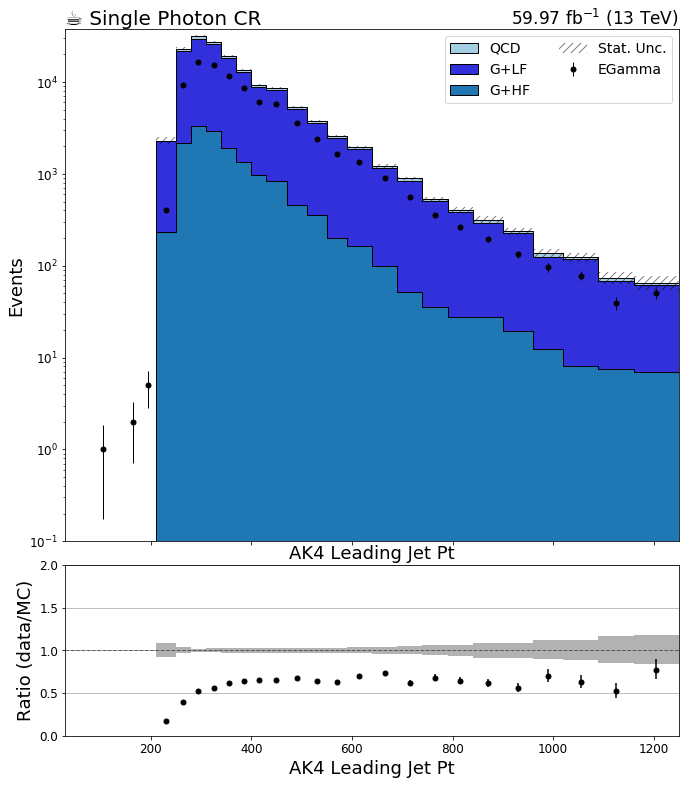

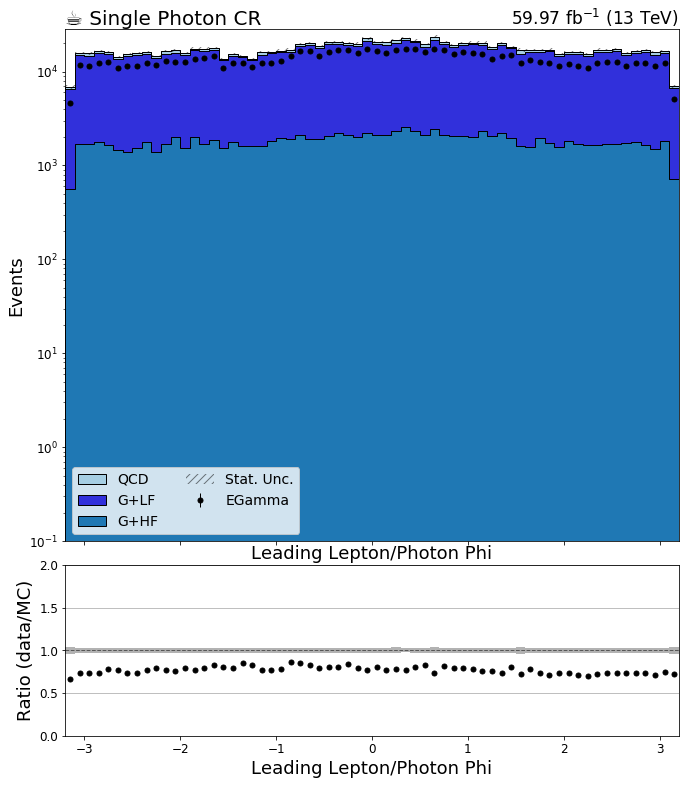

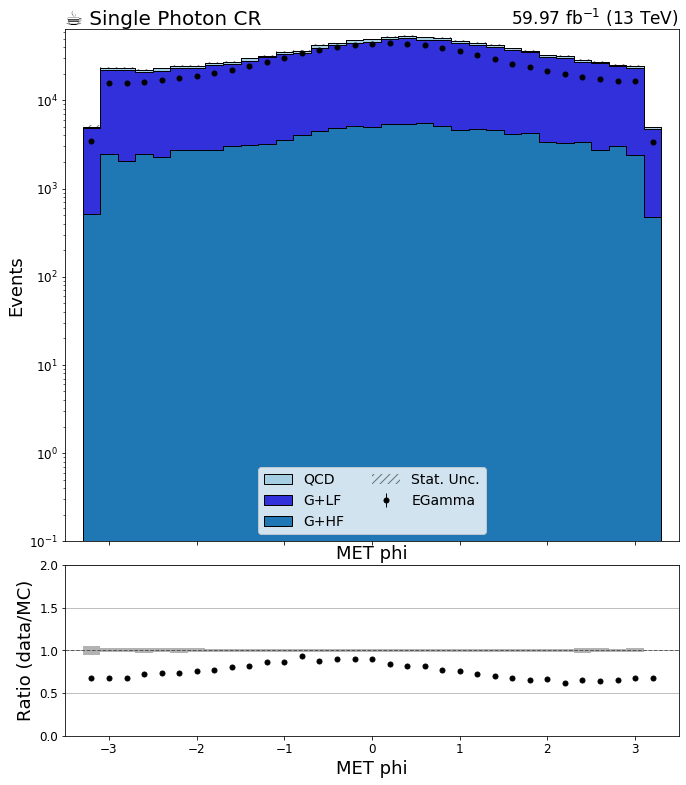

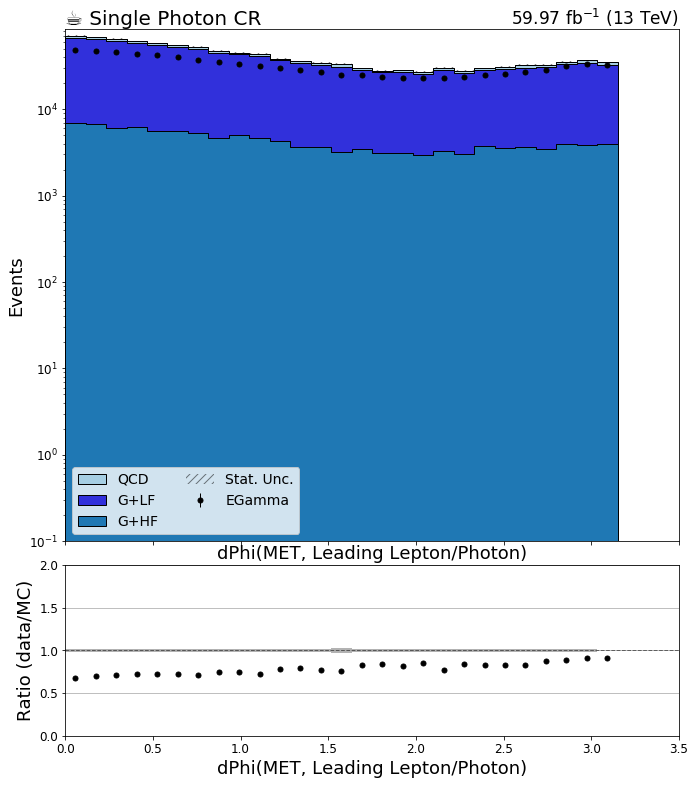

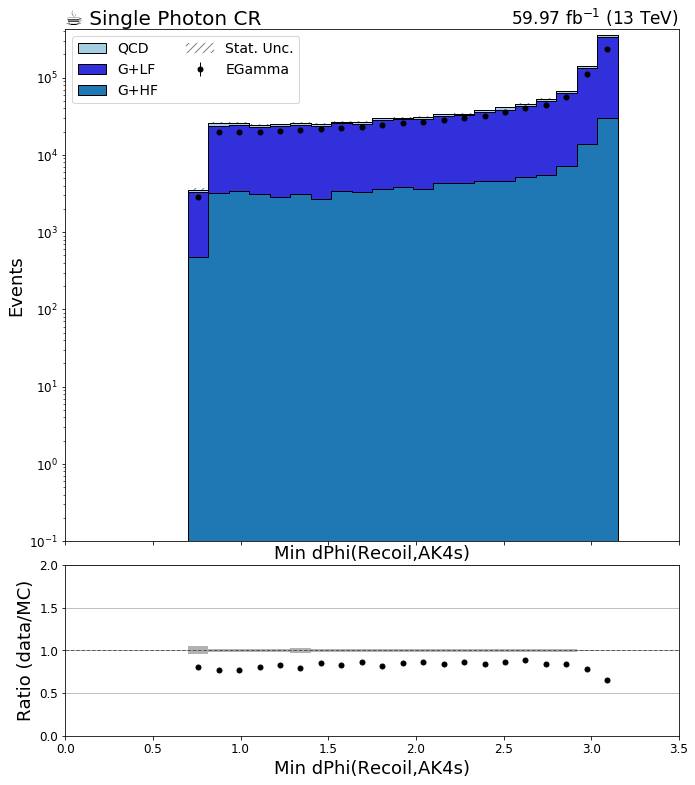

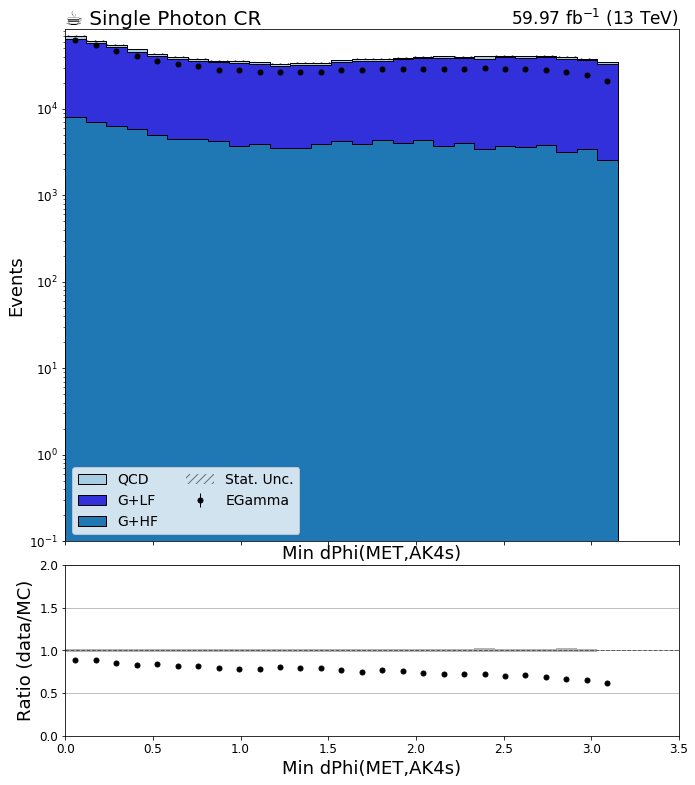

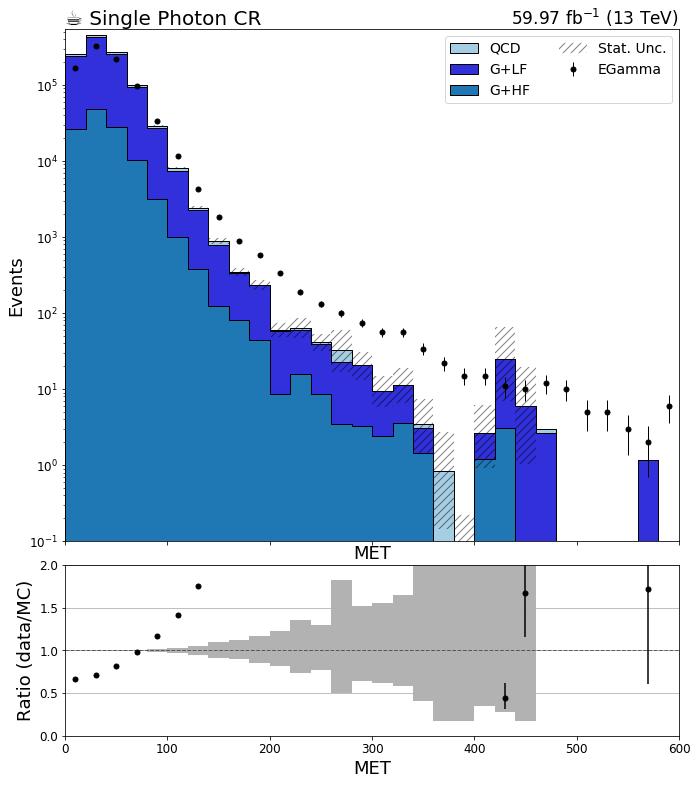

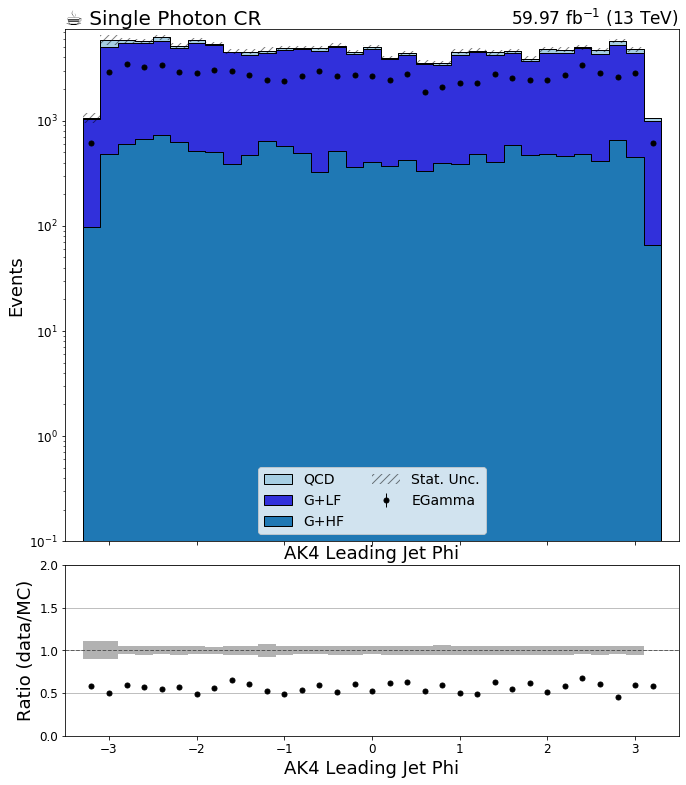

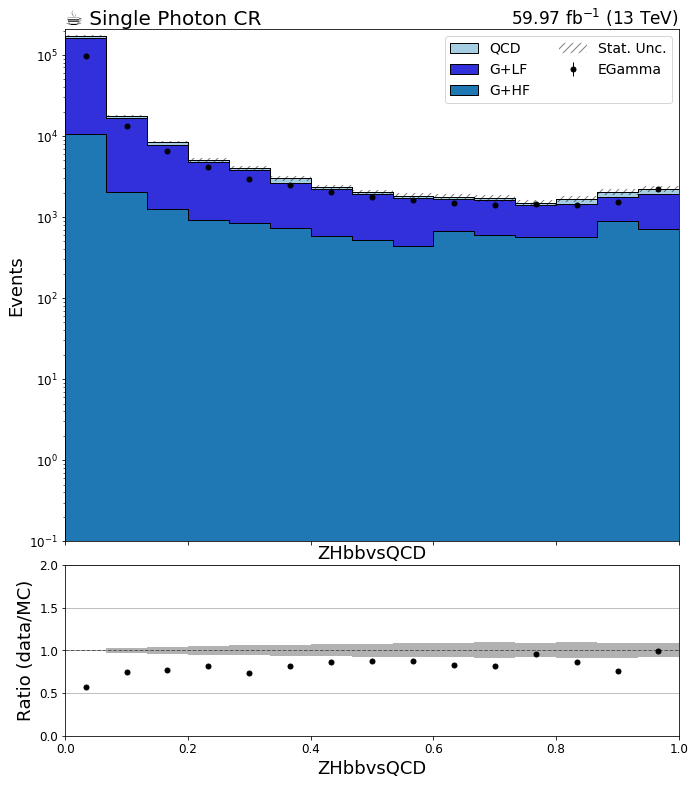

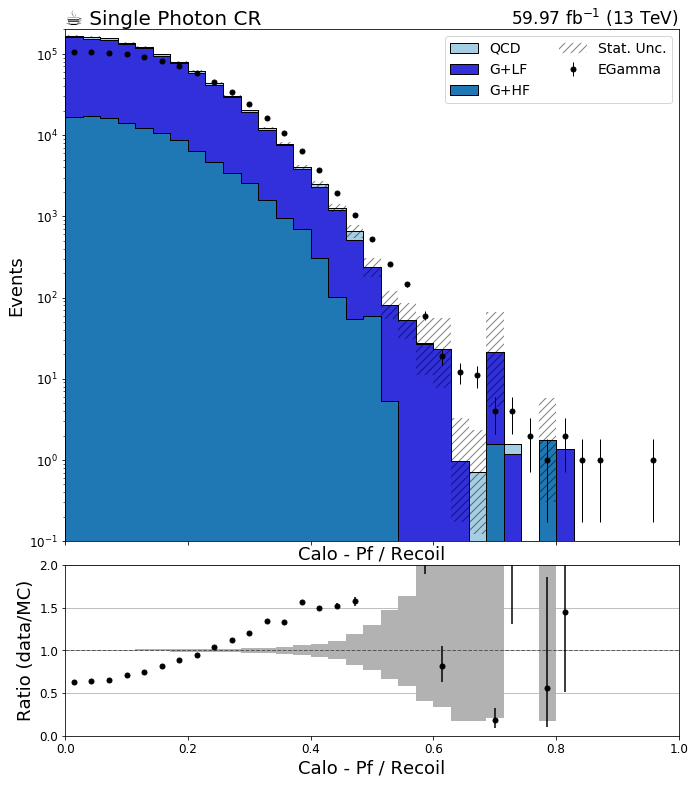

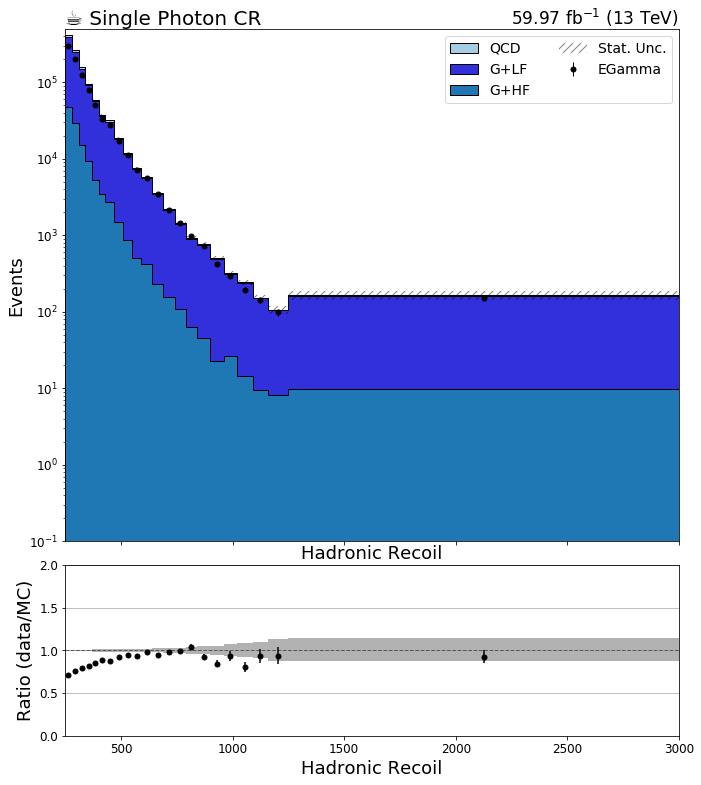

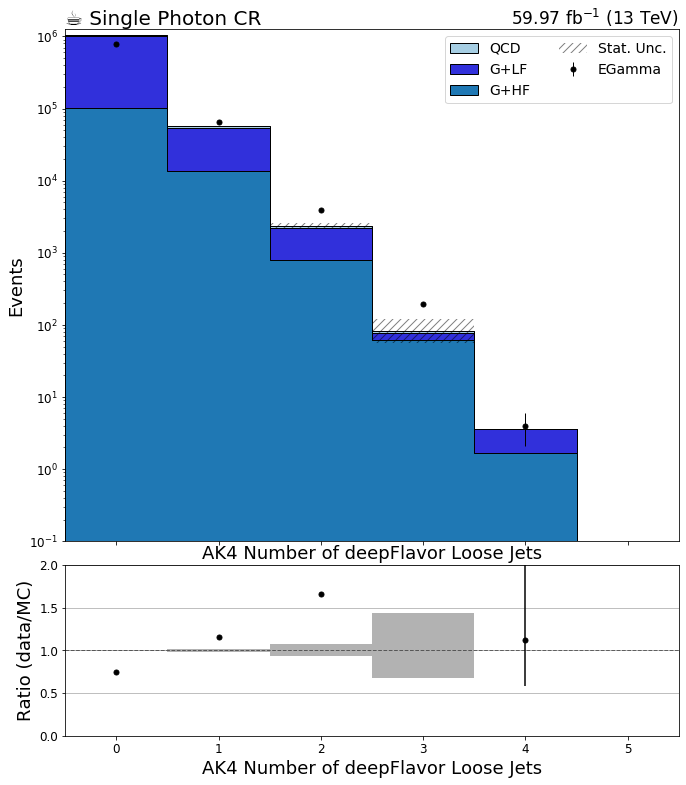

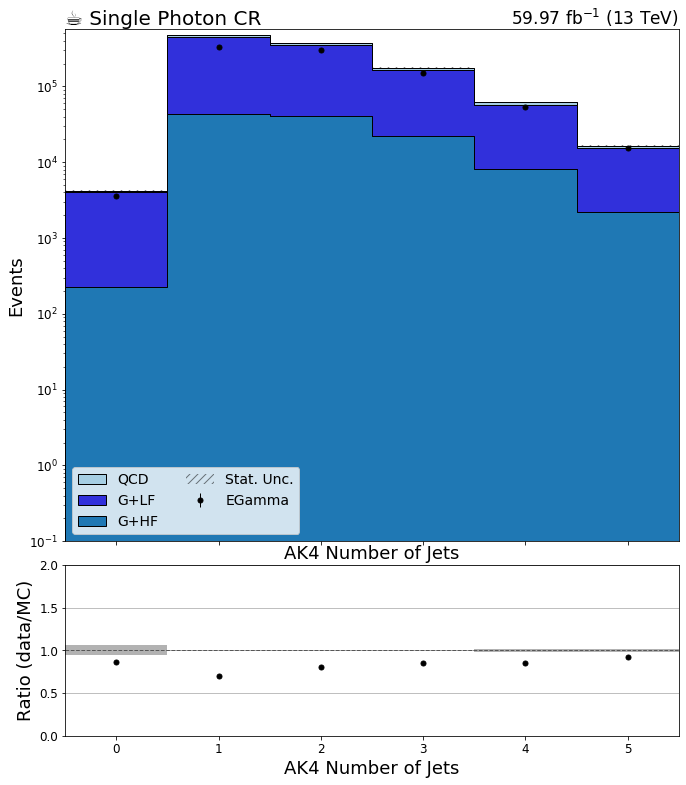

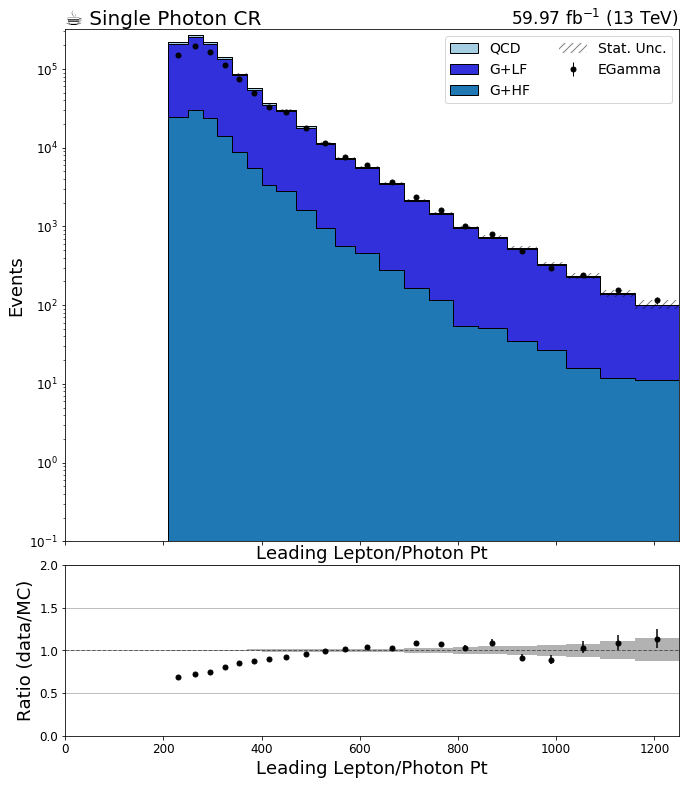

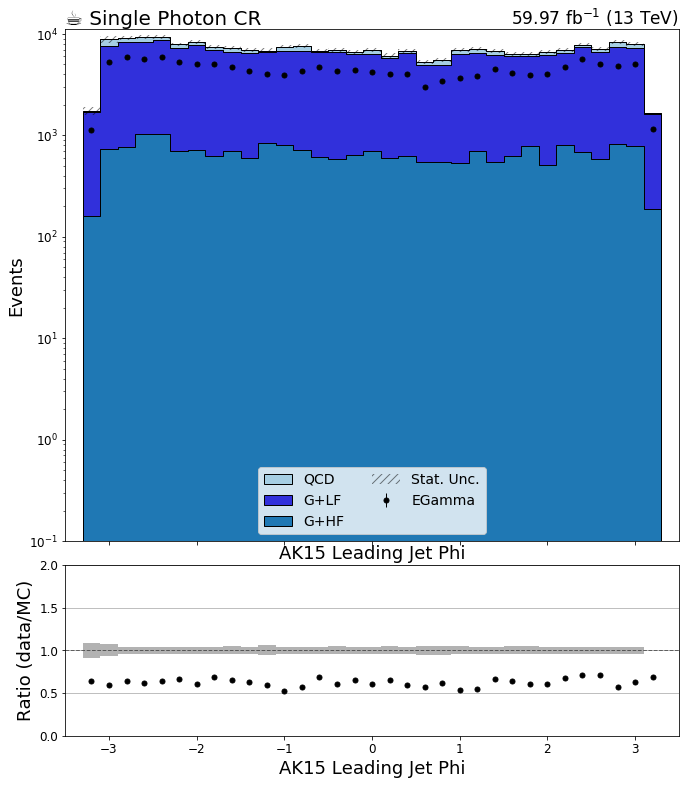

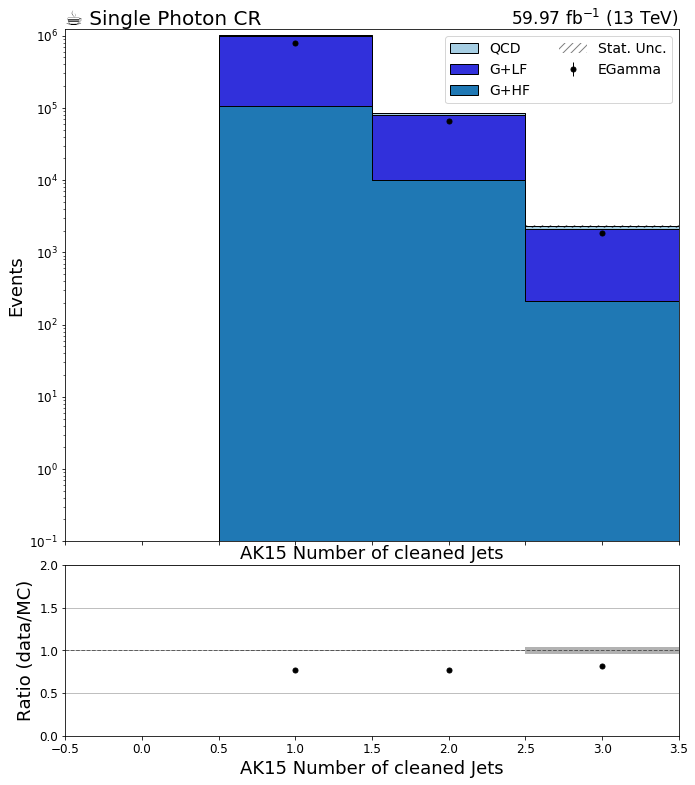

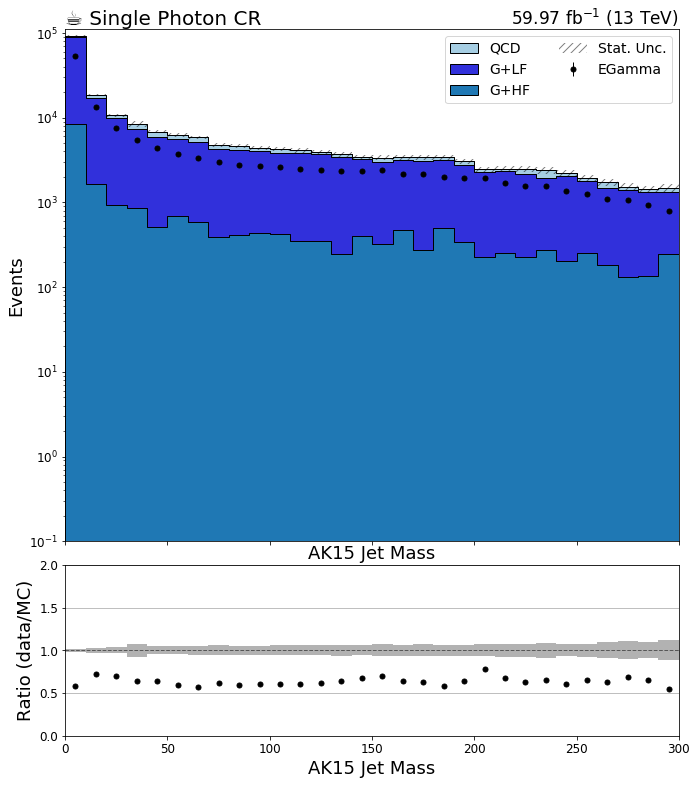

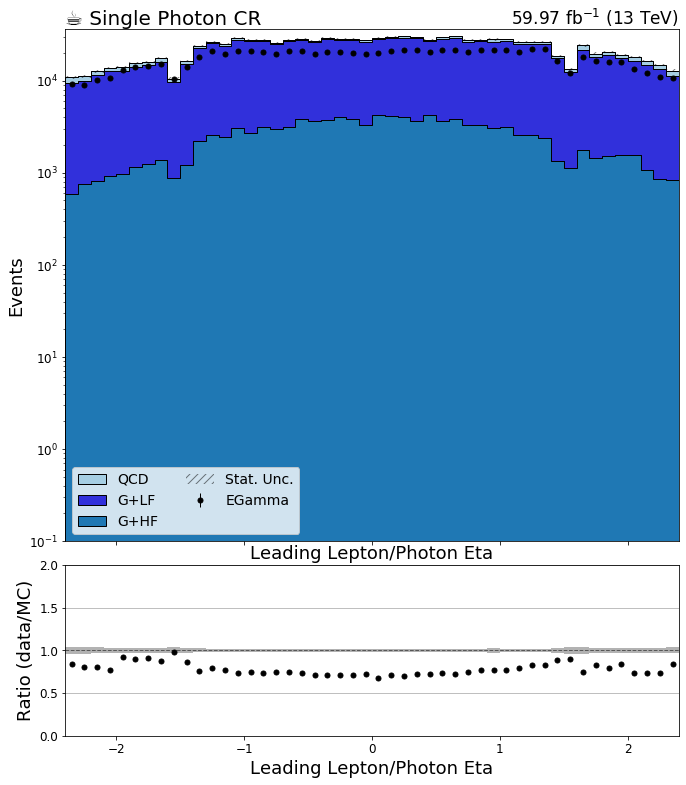

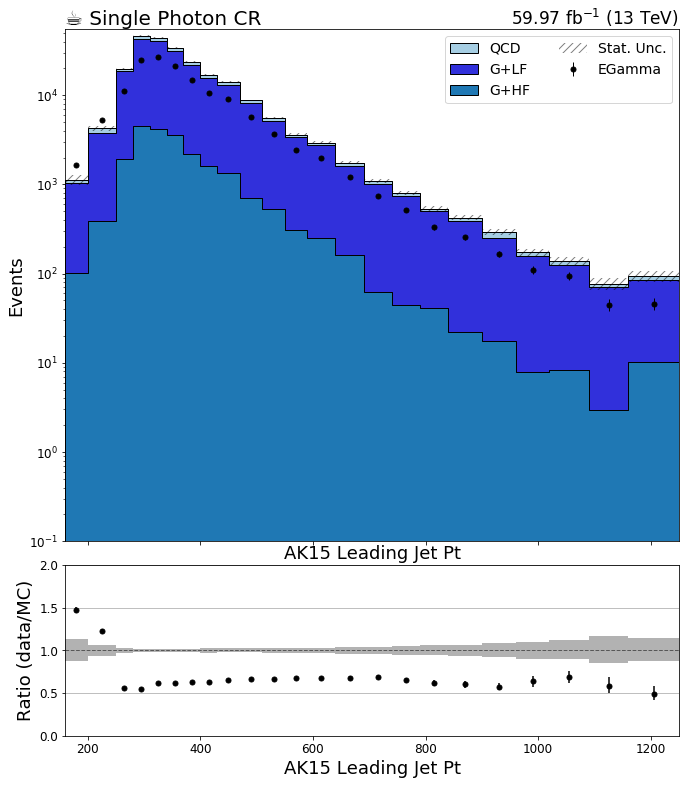

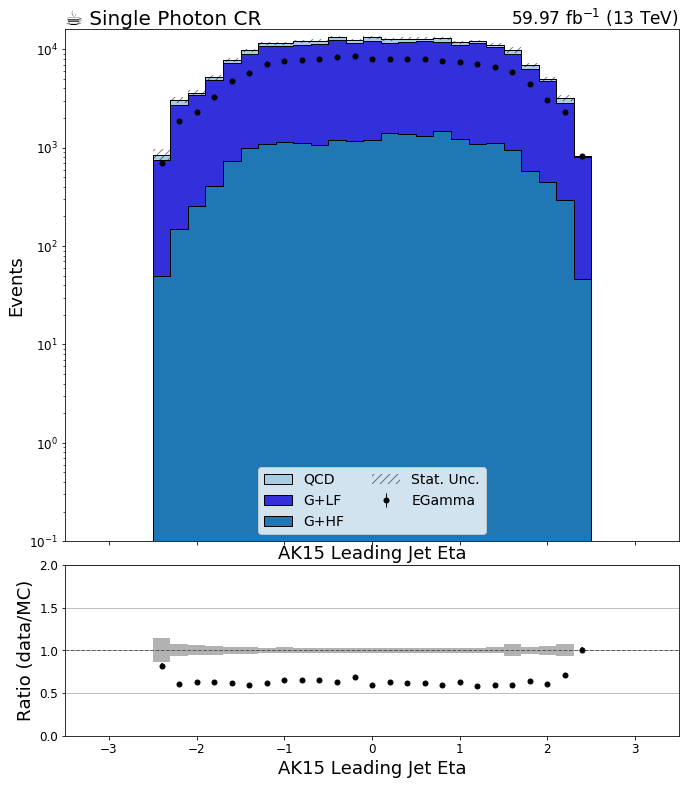

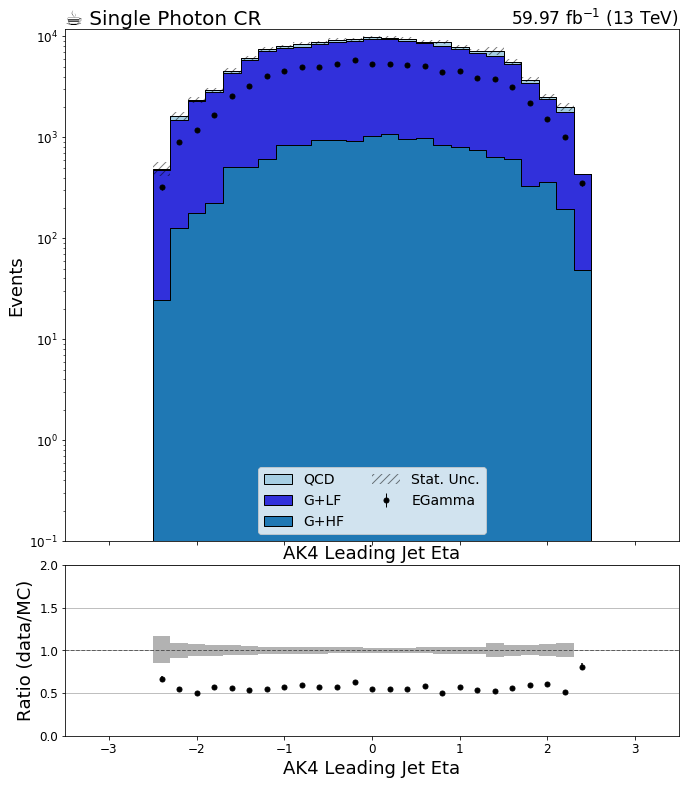

In [11]:
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler

region = 'gcr'
sys = 'nominal'



if not os.path.exists('../plots'):
    os.makedirs('../plots')
R = {}
R['sr'] = 'Signal Region'
R['wmcr'] = 'Single Muon W CR'
R['tmcr'] = 'Single Muon Top CR'
R['wecr'] = 'Single Electron W CR'
R['tecr'] = 'Single Electron Top CR'
R['zecr'] = 'Double Electron Z CR'
R['zmcr'] = 'Double Muon Z CR'
R['gcr'] = 'Single Photon CR'

for key in bkg_hists.keys():
    if key=='sumw': continue
    if key=='template': continue
    for j in bkg_hists[key].identifiers('region'):
        if not (str(j) == region): continue
        if 'mcr' in str(j):
            if 'e1' in key or 'diele' in key or 'pho' in key or 'mTe' in key: continue
        elif 'ecr' in str(j):
            if 'mu1' in key or 'dimu' in key or 'pho' in key or 'mTmu' in key: continue
        elif 'gcr' in str(j):
            if 'e1' in key or 'ele' in key or 'mu1' in key or 'dimu' in key or 'mT' in key: continue
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
        colors = ['#a6cee3', '#3130db', '#1f78b4', '#b2df8a', '#48e926', '#33a02c', '#c0df26',
                  '#fb9a99', '#d02ba7', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#c64bc4',
                  '#6a3d9a', '#a9ce26', '#ffff99', '#b15928', '#edcc43']


        fig, (ax, rax) = plt.subplots(2, 1, figsize=(11,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
        fig.subplots_adjust(hspace=.07)
        ax.set_prop_cycle(cycler(color=colors))
        
       
        plot.plot1d(data_hists[key].integrate('region',j).sum('gentype')[data[year][str(j)]],            
                overlay="process",
                ax=ax,
                clear=False,
                error_opts=data_err_opts
                   )

        plot.plot1d(bkg_hists[key].integrate('region',j).sum('gentype'),
                overlay="process",
                ax=ax,
                clear=False,
                stack=True,
                fill_opts=fill_opts,
                error_opts=error_opts
                   )
        
        plot.plotratio(data_hists[key].integrate('region',j).sum('gentype').integrate('process',data[year][str(j)]), 
                   bkg_hists[key].integrate('region',j).sum('gentype').sum('process'),
                   ax=rax,
                   #overflow='over',
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num'
                   )
        
        rax.set_ylabel('Ratio (data/MC)')
        rax.set_ylim(0.0,2.0)
        rax.grid(axis='y')
        
        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        if(key=='dielemass' or key=='dimumass'): ax.set_xlim(50, 130)
        ax.set_ylim(.1, None)
        leg = ax.legend(ncol=2, loc='best')
        
        coffee = plt.text(0., 1., u"☕ "+R[str(j).split('_')[0]], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        lumi = plt.text(1., 1., r"59.97 fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
        os.system('mkdir -p ../plots/darkhiggs'+year+'/'+str(j)+'/')
        plot_path = os.path.abspath('../plots/darkhiggs'+year+'/'+str(j)+'/') 
        plot_name = 'stack_'+key+'.png'
        fig.savefig(os.path.join(plot_path, plot_name))

In [4]:
process = hist.Cat("process", "Process", sorting='placement')
cats = ("process",)
sig_map = OrderedDict()
vjets_map = OrderedDict()
vjets_map["DY+jets"] = ("DY+*",)
vjets_map["W+jets"] = ("W+*",)
vjets_map["Z+jets"] = ("Z+*",)
vjets_map["G+jets"] = ("G+*",)
vjets_hists=bkg_hists['template'].group(cats, process, vjets_map)

In [5]:
vjets_hists.identifiers('systematic')

[<StringBin (btagDown) instance at 0x7f8df9ea5c50>,
 <StringBin (btagUp) instance at 0x7f8df9ea5c18>,
 <StringBin (ew1Down) instance at 0x7f8df9eab128>,
 <StringBin (ew1Up) instance at 0x7f8df9eab0b8>,
 <StringBin (ew2GDown) instance at 0x7f8df9eab1d0>,
 <StringBin (ew2GUp) instance at 0x7f8df9eab198>,
 <StringBin (ew2WDown) instance at 0x7f8df9eab278>,
 <StringBin (ew2WUp) instance at 0x7f8df9eab240>,
 <StringBin (ew2ZDown) instance at 0x7f8df9eab320>,
 <StringBin (ew2ZUp) instance at 0x7f8df9eab2e8>,
 <StringBin (ew3GDown) instance at 0x7f8df9eab3c8>,
 <StringBin (ew3GUp) instance at 0x7f8df9eab390>,
 <StringBin (ew3WDown) instance at 0x7f8df9eab470>,
 <StringBin (ew3WUp) instance at 0x7f8df9eab438>,
 <StringBin (ew3ZDown) instance at 0x7f8df9eab518>,
 <StringBin (ew3ZUp) instance at 0x7f8df9eab4e0>,
 <StringBin (mixDown) instance at 0x7f8df9eab5f8>,
 <StringBin (mixUp) instance at 0x7f8df9eab588>,
 <StringBin (muFDown) instance at 0x7f8df9ea5f28>,
 <StringBin (muFUp) instance at 0x7

In [82]:
systematic = hist.Cat("systematic", "systematics", sorting='placement')
cats = ("systematic",)
btag_map = OrderedDict()
btag_map["nominal"] = ("nominal", )
btag_map["btagDown"] = ("btagDown*", )
btag_map["btagUp"] = ("btagUp*", )
ewk1_map = OrderedDict()
ewk1_map["nominal"] = ("nominal", )
ewk1_map["ew1Down"] = ("ew1Down", )
ewk1_map["ew1Up"] = ("ew1Up", )
ewk1_map["mixDown"] = ("mixDown", )
ewk1_map["mixUp"] = ("mixUp", )
ewk2_map = OrderedDict()
ewk2_map["nominal"] = ("nominal", )
ewk2_map["ew2GDown"] = ("ew2GDown", )
ewk2_map["ew2GUp"] = ("ew2GUp", )
ewk2_map["ew2WDown"] = ("ew2WDown", )
ewk2_map["ew2WUp"] = ("ew2WUp", )
ewk2_map["ew2ZDown"] = ("ew2ZDown", )
ewk2_map["ew2ZUp"] = ("ew2ZUp", )
ewk3_map = OrderedDict()
ewk3_map["nominal"] = ("nominal", )
ewk3_map["ew3GDown"] = ("ew3GDown", )
ewk3_map["ew3GUp"] = ("ew3GUp", )
ewk3_map["ew3WDown"] = ("ew3WDown", )
ewk3_map["ew3WUp"] = ("ew3WUp", )
ewk3_map["ew3ZDown"] = ("ew3ZDown", )
ewk3_map["ew3ZUp"] = ("ew3ZUp", )
qcd_map = OrderedDict()
qcd_map["nominal"] = ("nominal", )
qcd_map["qcd1Down"] = ("qcd1Down", )
qcd_map["qcd1Up"] = ("qcd1Up", )
qcd_map["qcd2Down"] = ("qcd2Down", )
qcd_map["qcd2Up"] = ("qcd2Up", )
qcd_map["qcd3Down"] = ("qcd3Down", )
qcd_map["qcd3Up"] = ("qcd3Up", )
mu_map = OrderedDict()
mu_map["nominal"] = ("nominal", )
mu_map["muFDown"] = ("muFDown", )
mu_map["muFUp"] = ("muFUp", )
mu_map["muRDown"] = ("muRDown", )
mu_map["muRUp"] = ("muRUp", )

btag_hists=vjets_hists.group(cats, systematic, btag_map)
ewk1_hists=vjets_hists.group(cats, systematic, ewk1_map)
ewk2_hists=vjets_hists.group(cats, systematic, ewk2_map)
ewk3_hists=vjets_hists.group(cats, systematic, ewk3_map)
qcd_hists=vjets_hists.group(cats, systematic, qcd_map)
mu_hists=vjets_hists.group(cats, systematic, mu_map)

Text(0.55, 0.8, 'Z/DY')

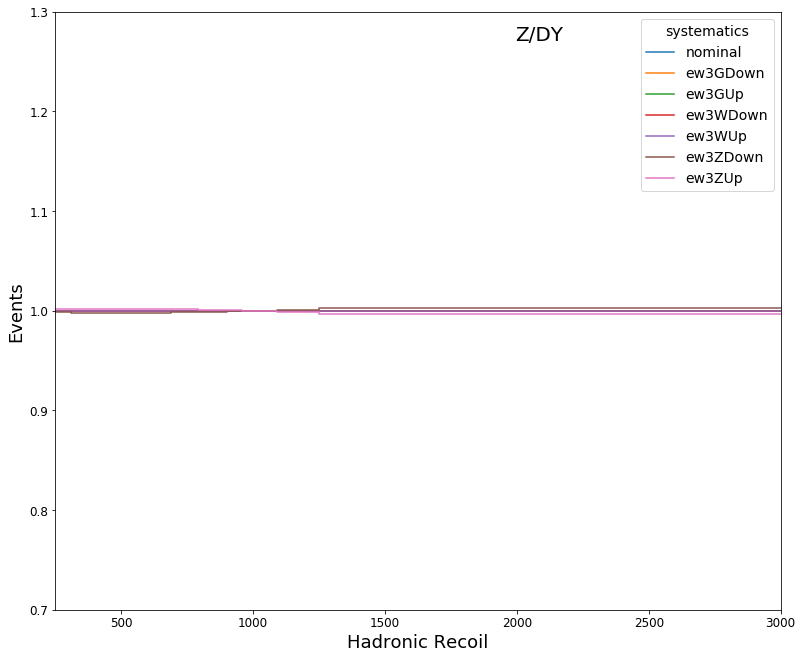

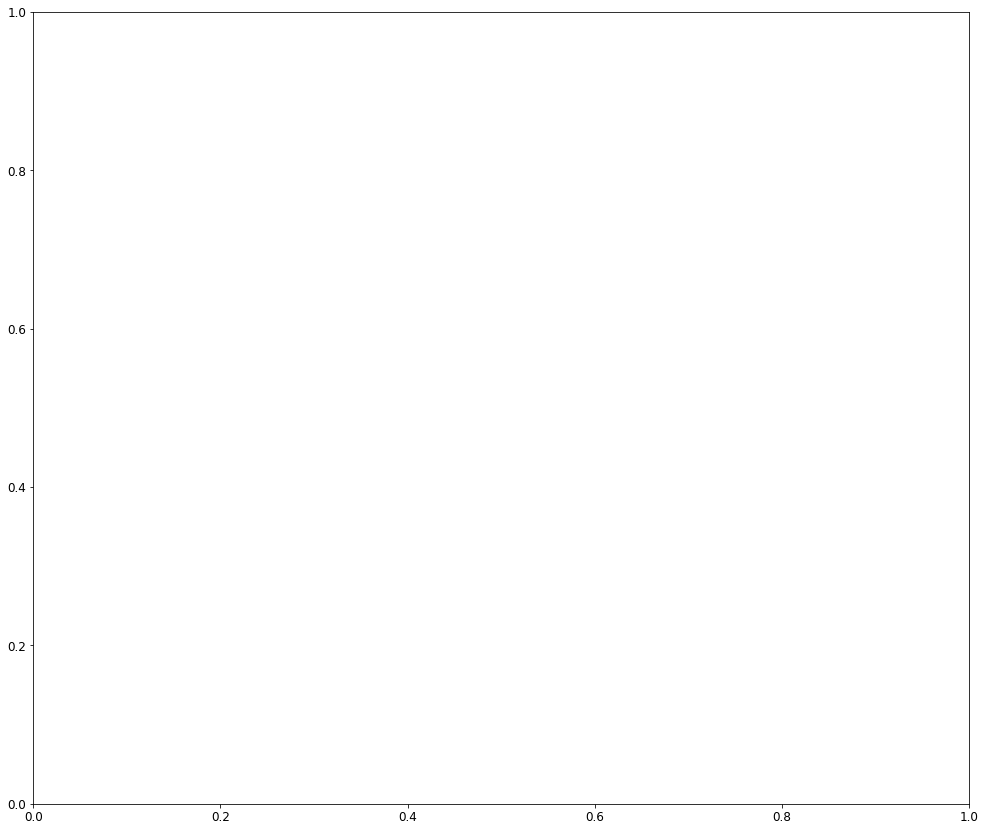

In [181]:
import matplotlib.patches as patches

syst_hists=ewk3_hists

dy=syst_hists.integrate('region','zmcr').integrate('process', 'DY+jets').sum('gentype','fjmass','ZHbbvsQCD',overflow='all')
z=syst_hists.integrate('region','sr').integrate('process', 'Z+jets').sum('gentype','fjmass','ZHbbvsQCD',overflow='all')
w=syst_hists.integrate('region','sr').integrate('process', 'W+jets').sum('gentype','fjmass','ZHbbvsQCD',overflow='all')
a=syst_hists.integrate('region','gcr').integrate('process', 'G+jets').sum('gentype','fjmass','ZHbbvsQCD',overflow='all')

for syst in dy.identifiers('systematic'):
    if str(syst) == 'nominal': continue
    dy.values()[(str(syst),)]/=dy.values()[('nominal',)]
    z.values()[(str(syst),)]/=z.values()[('nominal',)]
    w.values()[(str(syst),)]/=w.values()[('nominal',)]
    a.values()[(str(syst),)]/=a.values()[('nominal',)]
dy.values()[('nominal',)]/=dy.values()[('nominal',)]
z.values()[('nominal',)]/=z.values()[('nominal',)]
w.values()[('nominal',)]/=w.values()[('nominal',)]
a.values()[('nominal',)]/=a.values()[('nominal',)]

zw=syst_hists.integrate('region','sr').integrate('process', 'Z+jets').sum('gentype','fjmass','ZHbbvsQCD',overflow='all')
for syst in zw.identifiers('systematic'):
    if str(syst) == 'nominal': continue
    zw.values()[(str(syst),)]/=zw.values()[('nominal',)]
    zw.values()[(str(syst),)]/=w.values()[(str(syst),)]
    
za=syst_hists.integrate('region','sr').integrate('process', 'Z+jets').sum('gentype','fjmass','ZHbbvsQCD',overflow='all')
for syst in za.identifiers('systematic'):
    if str(syst) == 'nominal': continue
    za.values()[(str(syst),)]/=za.values()[('nominal',)]
    za.values()[(str(syst),)]/=a.values()[(str(syst),)]
    
zdy=syst_hists.integrate('region','sr').integrate('process', 'Z+jets').sum('gentype','fjmass','ZHbbvsQCD',overflow='all')
for syst in zdy.identifiers('systematic'):
    if str(syst) == 'nominal': continue
    zdy.values()[(str(syst),)]/=zdy.values()[('nominal',)]
    zdy.values()[(str(syst),)]/=dy.values()[(str(syst),)]

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(13,11)})
plot = hist.plot1d(zdy,overlay='systematic',error_opts=None,line_opts={'linestyle':'solid'})
plot.set_ylim(0.7, 1.3)
# build a rectangle in axes coords
left, width = .0, .55
bottom, height = .25, .55
right = left + width
top = bottom + height
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plot.text(right, top, 'Z/DY',
        fontsize=20, 
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)